In [53]:
from typing import Union, List, Union, Tuple, Optional
from matplotlib import pyplot as plt
import time 
from dataclasses import dataclass
from pyoxigraph import *
from rdflib import Graph, URIRef
from collections import defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
from IPython.display import display
import networkx as nx
import sys
import hashlib
import rdflib
from pprint import pprint

In [ ]:
sys.path.append('../utils')
sys.path.append('../../utils')
from namespaces import *
from utils import * 

B-Schema Algorithm 

1. Start with b-schema graph size 0, add a node from data graph
    - If first step, add a random node. All subsequent steps, add a node connected to graph 
2. Invert query graph to SPARQL with class and relation information, collect results 
3. If for the added node, all returned results already exist in the query, then this node is an already represented pattern. Remove it from the b-schema. 
4. Add nodes to b-schema until entire graph is covered. 

ADJUSTMENTS

Need to check if every triple is represented by the b-schema, not just every node. 
Need to check preferentially if a new triple can be represented by adding relationships between existing nodes. 

B-Schema Algorithm 

1. Start with b-schema graph size 0, add a node from data graph
    - If first step, add a random triple. All subsequent steps, add a node connected to graph, following a triple that is not represented by the b-schema, and add all triples connecting this node to the b-schema. 
2. Invert query graph to SPARQL with class and relation information
    - Run a construct query to reconstruct a graph and see which triples are represented by this query
3. If all triples are represented, end the process.
4. If not all triples are represented, repeat the process. 


NEXT STEP is probably adding some pruning. like if the nodes class is already present in the schema.
Making changes in algo testing now

Another statistical algorithm could just be turning the whole graph into a query, but limiting the results to 1, then running the query many times (would need some statistical measure of enough times). Then we could just say that all the things in a column together are in the same group, and say some columns are equivalent to build the schema. 

Implementation doesn't reqlly catch all the triples in a graph, especially things without classes or that may be unconnected

Issue with implementation, doesn't properly translate graph into query. Adding triples to schema but they're not getting represented. 


Algorithm doesn't seem to work. After a certain point, adding triples to the representation isn't increaseing the amount of triples represented by the query. perhaps at this point, adding another triple kicks out another triple to represent. My thinking was that the amount of triples represented would be monotonic, but if this is what's happening, then that isn't true. Perhaps this is also part of me having a limit in the query - at each step some triples will not be represented by the query. 


Can try collecting results using limit 1 and offset to sample, or using filter not equals to make sure I don't get multiple of the same results if not necessary. These approaches miss some triples. There may be a way to get the use of filters to work, but I can't think of a generalizable way to do this.

Can try and theorize about what most building systems look like (maybe a tree structure with some duplication from branch to branch) and try to have an algorithm that runs faster for graphs like this. Not thinking of a good way of avoiding collecting all the sparql results if I want a truly generalized approach. For specializing to certain kinds of structures, algorithms involve some guess and check. like:

1) add a node from the data graph
2) Invert into a query and run with limit 1 
3) Add a round of filter constraints for all results returned, and run the query again, ensuring there was no replication 
4) Optional step to consider: Add filters until there are no more results. Once there are no more results, change one of the last rounds of filters and collectg more results. I think this will not be helpfully so probably wouldn't implement
5) Select a new triple. This triple can be any not represented by the b-schema, but would preferably be one attached to the b-schema. Match it to existing triples in the b-schema Use BIND or filter with a SPARQL query to see if it is already represented by anything in the b-schema. If it is, added it to the set of triples represented by the CURRENT b-schema. Repeat this step until a new node has to be added to the data graph that is not represented, then rerun other steps. 

This algorithm assumes a structure that is interconnected with several parallel paths, and the filter not equals will reduce redundant triples while limiting increase in the query size. And it assumes we can get a pretty close to complete b-schema by representing individual blocks, then can just check the rest of the graph against the b-schema. 

Can also do a certain amount of binds based on the amount of instances of that class in the graph. This may help flesh out branches of the graph more before iterating through individual triples. 

It's also probably faster to check if a node is in the b-schema than to generate a new query and run again. However, running the queries with limit 1 can still take some time. It's also faster to run queries that are connected, so keeping the b-schema connected is important. 

Also may want to add nodes and add all relations conecting the nodes, since I could end up with weird duplicate structures in the graph if I do not do this. It adds some complexity so will skip for now. 

S223 is also harder, because there are parallel paths of connectivity, and some skipping of nodes in the connection statements. I think for s223, we must add all triples connecting two nodes. 

So new algorithm:
1. Start with b-schema graph size 0, add a triple or set of triples with the same subject and object from data graph to the b-schema
    - If first step, add a random triple. If there are other triples with the same subject and object, add all of these triples. All subsequent steps, add a triple connected to the existing b-schema, but not currently represented by the b-schema. 
2. Based on the classes and relations of the new triples, find a candidate statement in the b-schema that may represent this triple. 
3. Invert the b-schema statements to SPARQL queries with the class and relation information. 
4. Iteratively run queries with limit one with the identity of the added triple bound to the candidate statements.
    -  If one of these queries succeeds, the new triple should be added to the list of triples represented by a statement in the b-schema. 
    - If none of these queries succed, add the new triple to the b-schema as a new statement 
5. If all triples are represented, end the process, otherwise, repeat the process. 

In [3]:
g = Graph(store="Oxigraph")
g.parse("test-graph3.ttl", format="turtle")
query_to_df("SELECT * WHERE { ?s s223:cnx ?o }", g)

,o,s
0,urn:example#loop2,urn:example#loop2_2
1,urn:example#loop1,urn:example#loop1_2
2,urn:example#loop2_2,urn:example#loop2_1
3,urn:example#loop1_2,urn:example#loop1_1
4,urn:example#loop2_1,urn:example#loop2
5,urn:example#loop1_1,urn:example#loop1
6,urn:example#loop2,urn:example#root
7,urn:example#loop1,urn:example#root


In [4]:
from dataclasses import dataclass
from typing import Union, Set
from collections import defaultdict
from itertools import combinations
from rdflib import URIRef, Graph
import random

@dataclass(frozen=True)
class Triple:
    s: Union[str, list]
    p: Union[str, list]
    o: Union[str, list]


class PatternQuery:
    def __init__(self, triples, graph=None):
        self.triples = triples
        self.graph = graph
        self.prefixes = get_prefixes(graph)
        self.query_dict = self.make_var_names(triples)
        self.filters = self.add_filters(self.query_dict)
        self.where = self.add_where(self.query_dict)
        self.construct = self.add_construct(self.query_dict)
        self.queries = self.get_query()
        self.construct_query = self.get_construct_query()

    def add_filters(self, triples):
        filter_lst = []
        filter_dict = defaultdict(set)
        for class_triple, var_triple in triples:
            filter_dict[class_triple.s].add(var_triple.s)
            filter_dict[class_triple.o].add(var_triple.o)
        for klass, var_list in filter_dict.items():
            # SO hacky but getting AI code to work... 
            if URIRef(klass) == URIRef("http://www.w3.org/2000/01/rdf-schema#Resource"):
                continue
            if len(var_list) == 1:
                continue
            for var_1, var_2 in combinations(var_list, 2):
                filter_lst.append(f"FILTER (?{var_1} != ?{var_2}) .")

        return "\n".join(filter_lst)

    def make_var_names(self, triples):
        query_triples = []
        for class_triple, var_triple in triples:
            subject = self.get_local_name(var_triple.s).replace("-", "_")
            object = self.get_local_name(var_triple.o).replace("-", "_")
            if class_triple.p.startswith("<"):
                p_var = class_triple.p.split("<")[1].split(">")[0]
            else:
                p_var = class_triple.p
            query_triples.append((class_triple, Triple(subject, p_var, object)))
        return query_triples

    def get_local_name(self, node):
        node = str(node).replace("<", "").replace(">", "")
        if "#" in node:
            return node.rpartition("#")[-1]
        else:
            return node.rpartition("/")[-1]
    
    # NOTE: Shouldn't have used AI generated code for this - took as long or longer to debug as it would have taken to just write... 
    def add_where(self, query_triples):
        where = []
        added_type_assertions = set()
        
        for klass, var in query_triples:
            # Only add type assertions once per variable
            s_type_key = (var.s, klass.s)
            o_type_key = (var.o, klass.o)
            if s_type_key not in added_type_assertions:
                where.append(f"?{var.s} a {convert_to_prefixed(klass.s, self.graph)} .")
                added_type_assertions.add(s_type_key)

            
            if klass.o != "http://www.w3.org/2000/01/rdf-schema#Resource":
                if o_type_key not in added_type_assertions:
                    where.append(f"?{var.o} a {convert_to_prefixed(klass.o, self.graph)} .")
                    added_type_assertions.add(o_type_key)
                
            if URIRef(var.p) == A:
                continue 
            where.append(f"?{var.s} {convert_to_prefixed(URIRef(var.p), self.graph)} ?{var.o} .")
        
        return "\n".join(where)

    def add_construct(self, query_triples):
        """Create CONSTRUCT clause to reconstruct the graph pattern"""
        construct = []
        added_type_assertions = set()
        
        for klass, var in query_triples:
            s_type_key = (var.s, klass.s)
            o_type_key = (var.o, klass.o)

            
            if s_type_key not in added_type_assertions:
                construct.append(f"?{var.s} a {convert_to_prefixed(klass.s, self.graph)} .")
                added_type_assertions.add(s_type_key)
            
            if klass.o != "http://www.w3.org/2000/01/rdf-schema#Resource":
                if o_type_key not in added_type_assertions:
                    construct.append(f"?{var.o} a {convert_to_prefixed(klass.o, self.graph)} .")
                    added_type_assertions.add(o_type_key)

            if URIRef(var.p) == A:
                continue 
            construct.append(f"?{var.s} {convert_to_prefixed(URIRef(var.p), self.graph)} ?{var.o} .")
        
        return "\n".join(construct)

    def get_query(self):
        query = f"""{self.prefixes}\nSELECT DISTINCT * WHERE {{ {self.where}\n{self.filters} }}"""
        return query
    
    def get_construct_query(self):
        """Generate CONSTRUCT query to reconstruct graph"""
        query = f"""{self.prefixes}\nCONSTRUCT {{\n{self.construct}\n}} WHERE {{\n{self.where}\n{self.filters}\n}}"""
        return query


class BSchemaAlgorithm:
    def __init__(self, data_graph):
        """
        Initialize the B-Schema algorithm
        :param data_graph: RDFLib Graph containing the data
        """
        self.data_graph = data_graph
        self.b_schema_triples = []  # List of (class_triple, var_triple) tuples
        self.b_schema_set = set()  # Set for quick lookup
        self.represented_triples = Graph()
        self.all_triples = data_graph
        
    def get_triple_class_info(self, triple):
        """
        Get class information for a triple (subject class, predicate, object class)
        """
        s, p, o = triple
        
        # Get subject class
        s_classes = list(self.data_graph.objects(s, URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")))
        s_class = s_classes[0] if s_classes else URIRef("http://www.w3.org/2000/01/rdf-schema#Resource")
        
        # Get object class  
        o_classes = list(self.data_graph.objects(o, URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")))
        o_class = o_classes[0] if o_classes else URIRef("http://www.w3.org/2000/01/rdf-schema#Resource")
        
        return Triple(str(s_class), str(p), str(o_class)), Triple(str(s), str(p), str(o))
    
    def get_connected_triples(self, node):
        """
        Get all triples connected to a node (where node is subject or object)
        """
        connected = []
        for s, p, o in self.data_graph:
            if s == node or o == node:
                connected.append((s, p, o))
        return connected
    
    def get_nodes_in_schema(self):
        """Get all nodes (subjects and objects) currently in the b-schema"""
        nodes = set()
        for class_triple, var_triple in self.b_schema_triples:
            nodes.add(var_triple.s)
            nodes.add(var_triple.o)
        return nodes
    
    def triple_pattern_in_schema(self, class_triple):
        """Check if a class triple pattern is already in the schema"""
        for existing_class, _ in self.b_schema_triples:
            if (existing_class.s == class_triple.s and 
                existing_class.p == class_triple.p and 
                existing_class.o == class_triple.o):
                return True
        return False
    
    def run(self, max_iterations=100):
        """
        Execute the B-Schema algorithm
        """
        step = 0
        
        print(f"Total triples in data graph: {len(self.all_triples)}")
        
        while len(self.represented_triples) < len(self.all_triples) and step < max_iterations:
            step += 1
            print(f"\n{'='*60}")
            print(f"Step {step}")
            print(f"{'='*60}")
            
            # Step 1: Add a node to the b-schema graph
            if step == 1:
                # First step: add a random triple
                random_triple = random.choice(list(self.all_triples))
                class_triple, var_triple = self.get_triple_class_info(random_triple)
                self.b_schema_triples.append((class_triple, var_triple))
                self.b_schema_set.add((class_triple.s, class_triple.p, class_triple.o))
                print(f"Added initial triple: {random_triple}")
                print(f"Class pattern: ({class_triple.s}, {class_triple.p}, {class_triple.o})")
            else:
                # Add a node connected to the existing graph
                schema_nodes = self.get_nodes_in_schema()
                print(f"Current schema nodes: {len(schema_nodes)}")
                
                # Find triples not yet represented that connect to schema
                candidate_triples = []
                preferred_triples = []
                # skip literals
                for triple in self.all_triples:
                    if isinstance(triple, rdflib.Literal):
                        continue
                    if triple not in self.represented_triples:
                        candidate_triples.append(triple)
                        if ((triple[0], None, None) in self.represented_triples) or \
                            ((None, None, triple[2]) in self.represented_triples) or \
                            ((triple[2], None, None) in self.represented_triples) or \
                            ((None, None, triple[0]) in self.represented_triples):
                            preferred_triples.append(triple)
                
                print(f"Found {len(candidate_triples)} candidate triples")
                print(f"Found {len(preferred_triples)} preferred triples")
                if preferred_triples:
                    candidate_triples = preferred_triples
                if not candidate_triples:
                    print("No more connected triples found, but not all triples represented.")
                    print(f"Represented: {len(self.represented_triples)}, Total: {len(self.all_triples)}")
                    break
                
                # Choose a random candidate triple
                new_triple = random.choice(candidate_triples)
                s, p, o = new_triple
                
                # Add the new triple pattern
                class_triple, var_triple = self.get_triple_class_info(new_triple)
                self.b_schema_triples.append((class_triple, var_triple))
                self.b_schema_set.add((class_triple.s, class_triple.p, class_triple.o))
                print(f"Added triple: {new_triple}")
                print(f"Class pattern: ({class_triple.s}, {class_triple.p}, {class_triple.o})")
            
            # Step 2: Invert to SPARQL CONSTRUCT query and execute
            pattern_query = PatternQuery(self.b_schema_triples, self.data_graph)
            construct_query = pattern_query.get_construct_query()
            self.pattern_query = pattern_query
            self.query = pattern_query.get_query()
            print(f"\nCONSTRUCT Query:\n{construct_query}\n")
            

            result_graph = self.data_graph.query(construct_query).graph
            result_graph.print()
            self.represented_triples = result_graph
            
            represented = 0 
            for s, p, o in self.all_triples:
                if (s, p, o) in self.represented_triples:
                    represented += 1
                

            
            print(f"Triples represented: {represented}/{len(self.all_triples)}")
            
            # Step 3: Check if all triples are represented
            if represented == len(self.all_triples):
                print("\n" + "="*60)
                print("SUCCESS: All triples represented! Algorithm complete.")
                print("="*60)
                break
        
            if step >= max_iterations:
                print(f"\nReached maximum iterations ({max_iterations})")
        
        return self.b_schema_triples, pattern_query


# Helper functions
def get_prefixes(graph):
    """Generate prefix declarations from graph namespaces"""
    if graph is None:
        return ""
    prefixes = []
    for prefix, namespace in graph.namespaces():
        if prefix:  # Skip empty prefix
            prefixes.append(f"PREFIX {prefix}: <{namespace}>")
    return "\n".join(prefixes)


def convert_to_prefixed(uri, graph):
    """Convert URI to prefixed form if possible"""
    if graph is None:
        return f"<{uri}>"
    
    uri_str = str(uri)
    for prefix, namespace in graph.namespaces():
        namespace_str = str(namespace)
        if uri_str.startswith(namespace_str):
            local_name = uri_str[len(namespace_str):]
            if prefix:
                return f"{prefix}:{local_name}"
    return f"<{uri}>"

In [5]:
data_graph = Graph(store="Oxigraph")
data_graph.parse("test-graph3.ttl", format="turtle")
algorithm = BSchemaAlgorithm(data_graph)
b_schema, final_query = algorithm.run()

Total triples in data graph: 15

Step 1
Added initial triple: (rdflib.term.URIRef('urn:example#loop1_1'), rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), rdflib.term.URIRef('urn:example#loop1_2'))
Class pattern: (http://data.ashrae.org/standard223#Branch, http://data.ashrae.org/standard223#cnx, http://data.ashrae.org/standard223#Branch)

CONSTRUCT Query:
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PRE

In [17]:
algorithm.all_triples.print()

@prefix ex: <urn:example#> .
@prefix s223: <http://data.ashrae.org/standard223#> .

ex:root a s223:Root ;
    s223:cnx ex:loop1,
        ex:loop2 .

ex:loop1_1 a s223:Branch ;
    s223:cnx ex:loop1_2 .

ex:loop1_2 a s223:Branch ;
    s223:cnx ex:loop1 .

ex:loop2_1 a s223:Branch ;
    s223:cnx ex:loop2_2 .

ex:loop2_2 a s223:Branch ;
    s223:cnx ex:loop2 .

ex:loop1 a s223:Branch ;
    s223:cnx ex:loop1_1 .

ex:loop2 a s223:Branch ;
    s223:cnx ex:loop2_1 .




In [18]:
len(algorithm.all_triples)

15

In [19]:
len(algorithm.represented_triples)

15

In [20]:
algorithm.represented_triples.print()

@prefix ns1: <http://data.ashrae.org/standard223#> .

<urn:example#root> a ns1:Root ;
    ns1:cnx <urn:example#loop1>,
        <urn:example#loop2> .

<urn:example#loop1_1> a ns1:Branch ;
    ns1:cnx <urn:example#loop1_2> .

<urn:example#loop1_2> a ns1:Branch ;
    ns1:cnx <urn:example#loop1> .

<urn:example#loop2_1> a ns1:Branch ;
    ns1:cnx <urn:example#loop2_2> .

<urn:example#loop2_2> a ns1:Branch ;
    ns1:cnx <urn:example#loop2> .

<urn:example#loop1> a ns1:Branch ;
    ns1:cnx <urn:example#loop1_1> .

<urn:example#loop2> a ns1:Branch ;
    ns1:cnx <urn:example#loop2_1> .




In [21]:
print(algorithm.query)

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [22]:
query_to_df(algorithm.query, algorithm.all_triples) 

,loop2,loop2_1,loop2_2,root
0,urn:example#loop2,urn:example#loop1,urn:example#loop1_1,urn:example#root
1,urn:example#loop2,urn:example#loop1_1,urn:example#loop1_2,urn:example#root
2,urn:example#loop2,urn:example#loop2_1,urn:example#loop2_2,urn:example#root
3,urn:example#loop2,urn:example#loop1_2,urn:example#loop1,urn:example#root
4,urn:example#loop1,urn:example#loop2,urn:example#loop2_1,urn:example#root
5,urn:example#loop1,urn:example#loop1_1,urn:example#loop1_2,urn:example#root
6,urn:example#loop1,urn:example#loop2_1,urn:example#loop2_2,urn:example#root
7,urn:example#loop1,urn:example#loop2_2,urn:example#loop2,urn:example#root


In [23]:
print(algorithm.pattern_query.get_construct_query())

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [24]:
# SHORTER query gets me same results. Algorithm isn't working
query = """
CONSTRUCT {
?root a s223:Root .
?branch3 a s223:Branch .
?branch3 s223:cnx ?leaf1 .
?leaf1 a s223:Leaf .
?root s223:cnx ?branch1 .
?branch1 a s223:Branch .
?root s223:cnx ?branch3 .
?branch3 s223:cnx ?leaf1 .
?branch3 s223:cnx ?leaf1 .
?root s223:cnx ?branch1 .
?branch3 s223:cnx ?leaf3 .
?leaf3 a s223:Leaf .
} WHERE {
?root a s223:Root .
?branch3 a s223:Branch .
?branch3 s223:cnx ?leaf1 .
?leaf1 a s223:Leaf .
?root s223:cnx ?branch1 .
?branch1 a s223:Branch .
?root s223:cnx ?branch3 .
?branch3 s223:cnx ?leaf1 .
?branch3 s223:cnx ?leaf1 .
?root s223:cnx ?branch1 .
?branch3 s223:cnx ?leaf3 .
?leaf3 a s223:Leaf .
FILTER (?branch1 != ?branch3) .
FILTER (?leaf1 != ?leaf3) .
}"""

In [25]:
algorithm.all_triples.query(query).graph.print()

In [26]:
algorithm.represented_triples.print()

@prefix ns1: <http://data.ashrae.org/standard223#> .

<urn:example#root> a ns1:Root ;
    ns1:cnx <urn:example#loop1>,
        <urn:example#loop2> .

<urn:example#loop1_1> a ns1:Branch ;
    ns1:cnx <urn:example#loop1_2> .

<urn:example#loop1_2> a ns1:Branch ;
    ns1:cnx <urn:example#loop1> .

<urn:example#loop2_1> a ns1:Branch ;
    ns1:cnx <urn:example#loop2_2> .

<urn:example#loop2_2> a ns1:Branch ;
    ns1:cnx <urn:example#loop2> .

<urn:example#loop1> a ns1:Branch ;
    ns1:cnx <urn:example#loop1_1> .

<urn:example#loop2> a ns1:Branch ;
    ns1:cnx <urn:example#loop2_1> .




In [27]:
algorithm.represented_triples

<Graph identifier=Ncc43306dc9eb4c0baf097211aedaa274 (<class 'rdflib.graph.Graph'>)>

In [28]:
print(final_query.get_construct_query())

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [29]:
query = """CONSTRUCT {
?root a s223:Root .
?root s223:cnx ?branch2 .
?branch2 a s223:Branch .
?branch3 a s223:Branch .
?branch3 s223:cnx ?leaf1 .
?leaf1 a s223:Leaf .
} WHERE {
?root a s223:Root .
?root s223:cnx ?branch2 .
?branch2 a s223:Branch .
?branch3 a s223:Branch .
?branch3 s223:cnx ?leaf1 .
?leaf1 a s223:Leaf .
FILTER (?branch2 != ?branch3) .
FILTER (?leaf1 != ?leaf3) .
}"""
algorithm.all_triples.query(query).graph.print()

In [30]:
data_graph = Graph(store="Oxigraph")
data_graph.parse("test-graph-long.ttl", format="turtle")
algorithm = BSchemaAlgorithm(data_graph)
b_schema, final_query = algorithm.run()

Total triples in data graph: 49

Step 1
Added initial triple: (rdflib.term.URIRef('urn:example#leaf12'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://data.ashrae.org/standard223#Leaf'))
Class pattern: (http://data.ashrae.org/standard223#Leaf, http://www.w3.org/1999/02/22-rdf-syntax-ns#type, http://www.w3.org/2000/01/rdf-schema#Resource)

CONSTRUCT Query:
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX

In [31]:
query_to_df(algorithm.query, algorithm.all_triples) 


,branch1,branch2,branch3,leaf111111,leaf1111111,leaf12,leaf3,root
0,urn:example#branch1,urn:example#branch2,urn:example#branch3,urn:example#leaf11,urn:example#leaf111,urn:example#leaf1,urn:example#leaf3,urn:example#root
1,urn:example#branch1,urn:example#branch2,urn:example#branch3,urn:example#leaf11,urn:example#leaf112,urn:example#leaf1,urn:example#leaf3,urn:example#root
2,urn:example#branch1,urn:example#branch2,urn:example#branch3,urn:example#leaf11,urn:example#leaf113,urn:example#leaf1,urn:example#leaf3,urn:example#root
3,urn:example#branch1,urn:example#branch2,urn:example#branch3,urn:example#leaf111,urn:example#leaf1111,urn:example#leaf1,urn:example#leaf3,urn:example#root
4,urn:example#branch1,urn:example#branch2,urn:example#branch3,urn:example#leaf111,urn:example#leaf1112,urn:example#leaf1,urn:example#leaf3,urn:example#root
...,...,...,...,...,...,...,...,...
1831,urn:example#branch2,urn:example#branch1,urn:example#branch3,urn:example#leaf11111,urn:example#leaf111111,urn:example#leaf1111113,urn:example#leaf1,urn:example#root
1832,urn:example#branch2,urn:example#branch1,urn:example#branch3,urn:example#leaf11111,urn:example#leaf111112,urn:example#leaf1111113,urn:example#leaf1,urn:example#root
1833,urn:example#branch2,urn:example#branch1,urn:example#branch3,urn:example#leaf11111,urn:example#leaf111113,urn:example#leaf1111113,urn:example#leaf1,urn:example#root
1834,urn:example#branch2,urn:example#branch1,urn:example#branch3,urn:example#leaf111111,urn:example#leaf1111111,urn:example#leaf1111113,urn:example#leaf1,urn:example#root


In [32]:
data_graph = Graph(store="Oxigraph")
data_graph.parse("vrf-model-cut.ttl", format="turtle")
algorithm = BSchemaAlgorithm(data_graph)
b_schema, final_query = algorithm.run()

Total triples in data graph: 258

Step 1
Added initial triple: (rdflib.term.URIRef('http://data.ashrae.org/standard223/data/scb-vrf#00010'), rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), rdflib.term.URIRef('http://data.ashrae.org/standard223/data/scb-vrf#00009'))
Class pattern: (http://www.w3.org/2000/01/rdf-schema#Resource, http://data.ashrae.org/standard223#cnx, http://www.w3.org/2000/01/rdf-schema#Resource)

CONSTRUCT Query:
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: 

KeyboardInterrupt: 

# OLD 

In [ ]:
from collections import defaultdict, deque
from itertools import combinations
from dataclasses import dataclass
from typing import Union, Set, Tuple, List
from rdflib import URIRef
import random

@dataclass(frozen=True)
class Triple:
    s: Union[str, list]
    p: Union[str, list]
    o: Union[str, list]


class PatternQuery:
    def __init__(self, triples, graph=None):
        self.triples = triples
        self.graph = graph
        self.prefixes = get_prefixes(graph)
        self.query_dict = self.make_var_names(triples)
        self.filters = self.add_filters(self.query_dict)
        self.where = self.add_where(self.query_dict)
        self.queries = self.get_query()

    def add_filters(self, triples):
        filter_lst = []
        # anything of the same class should not equal another var of the same class
        filter_dict = defaultdict(set)
        for class_triple, var_triple in triples:
            filter_dict[class_triple.s].add(var_triple.s)
            filter_dict[class_triple.o].add(var_triple.o)
        for klass, var_list in filter_dict.items():
            if len(var_list) == 1:
                continue
            for var_1, var_2 in combinations(var_list, 2):
                filter_lst.append(f"FILTER (?{var_1} != ?{var_2}) .")

        return "\n".join(filter_lst)

    def make_var_names(self, triples):
        counter = {}
        query_triples = []
        var_names = set()
        for class_triple, var_triple in triples:
            subject = self.get_local_name(var_triple.s).replace("-", "_")
            object = self.get_local_name(var_triple.o).replace("-", "_")
            if class_triple.p.startswith("<"):
                p_var = class_triple.p.split("<")[1].split(">")[0]
            else:
                p_var = class_triple.p
            query_triples.append((class_triple, Triple(subject, p_var, object)))
        return query_triples

    def get_local_name(self, node):
        node = str(node).replace("<", "").replace(">", "")
        if "#" in node:
            return node.rpartition("#")[-1]
        else:
            return node.rpartition("/")[-1]

    def add_where(self, query_triples):
        where = []
        for klass, var in query_triples:
            where.append(f"?{var.s} a {convert_to_prefixed(klass.s, self.graph)} .")
            where.append(f"?{var.s} {convert_to_prefixed(URIRef(var.p), self.graph)} ?{var.o} .")
            where.append(f"?{var.o} a {convert_to_prefixed(klass.o, self.graph)} .")
        return "\n".join(where)

    def get_query(self):
        query = f"""{self.prefixes}\nSELECT DISTINCT * WHERE {{ {self.where}\n{self.filters} }}"""
        return query
    
    def construct_query(self):
        query = f"""{self.prefixes}\nCONSTRUCT {{*}} WHERE {{ {self.where}\n{self.filters} }}"""
        return query

In [ ]:
from collections import defaultdict

class BSchemaExtractor:
    def __init__(self, data_graph):
        self.data_graph = data_graph
        self.b_schema = []  # List of triples in the b-schema
        self.matched_triples = set()  # Triples matched by current b-schema query results
        self.all_data_triples = self._extract_all_triples()
        self.schema_to_instances = {}  # Mapping from b-schema variables to actual instances
        
    def _extract_all_triples(self):
        """Extract all triples from the data graph with class information"""
        triples = []
        for s, p, o in self.data_graph:
            # Get class information for subject and object
            s_class = self._get_node_class(s)
            o_class = self._get_node_class(o)
            if s_class and o_class:
                class_triple = Triple(s_class, p, o_class)
                var_triple = Triple(s, p, o)
                triples.append((class_triple, var_triple))
        return triples
    
    def _get_node_class(self, node):
        """Get the class of a node from the data graph"""
        from rdflib import RDF
        for s, p, o in self.data_graph.triples((node, RDF.type, None)):
            return o
        return None
    
    def _get_all_graph_triples(self):
        """Get all data triples as a set for comparison"""
        all_triples = set()
        for class_triple, var_triple in self.all_data_triples:
            all_triples.add((var_triple.s, var_triple.p, var_triple.o))
        return all_triples
    
    def _get_connected_uncovered_triples(self):
        """Get triples connected to current b-schema but not yet matched"""
        if not self.b_schema:
            return self.all_data_triples
        
        current_nodes = set()
        # Get all nodes in current b-schema
        for class_triple, var_triple in self.b_schema:
            current_nodes.add(var_triple.s)
            current_nodes.add(var_triple.o)
        
        # Find triples connected to current b-schema that aren't already matched
        connected_triples = []
        for class_triple, var_triple in self.all_data_triples:
            triple_tuple = (var_triple.s, var_triple.p, var_triple.o)
            
            # Skip if this triple is already matched by current pattern
            if triple_tuple in self.matched_triples:
                continue
            
            # Check if connected to current b-schema
            if var_triple.s in current_nodes or var_triple.o in current_nodes:
                connected_triples.append((class_triple, var_triple))
        
        return connected_triples
    
    def _execute_query_and_get_matched_triples(self, query):
        """Execute SPARQL query and reconstruct which actual data triples are matched"""
        results = self.data_graph.query(query)
        matched_triples = set()
        result_set = set()
        
        # Get variable names from results
        var_names = [str(v) for v in results.vars]
        
        for row in results:
            result_set.add(tuple(row))
            # Map variable bindings back to see which triples they represent
            binding = {var_names[i]: row[i] for i in range(len(var_names))}
            
            # For each triple in b-schema, find the actual data triple it matches
            for class_triple, var_triple in self.b_schema:
                # Get the actual nodes from the binding
                s_var = self._get_var_name(var_triple.s)
                o_var = self._get_var_name(var_triple.o)
                
                if s_var in binding and o_var in binding:
                    actual_s = binding[s_var]
                    actual_o = binding[o_var]
                    # Add the actual data triple
                    matched_triples.add((actual_s, var_triple.p, actual_o))
        
        return result_set, matched_triples
    
    def _get_var_name(self, var):
        """Get the variable name without the '?' prefix"""
        return str(var).replace("-", "_").split("#")[-1].split("/")[-1]
    
    def _node_already_represented(self, new_triple, old_results):
        """Check if adding a node creates a pattern already represented"""
        if len(self.b_schema) == 0:
            return False
        
        # Get results with new node added
        test_schema = self.b_schema.copy()
        test_schema.append(new_triple)
        new_query = PatternQuery(test_schema, self.data_graph).get_query()
        new_results, _ = self._execute_query_and_get_matched_triples(new_query)
        
        # If all new results already exist in old results, pattern is redundant
        return new_results.issubset(old_results)
    
    def _create_schema_mapping(self, final_query):
        """
        Create a mapping from b-schema variable names to the set of actual instances
        that each variable represents across all query results.
        
        Returns a dictionary where:
        - Key: variable name from b-schema (e.g., 'loop1', 'root')
        - Value: set of all actual nodes that this variable matched (e.g., {ex:loop1, ex:loop2})
        """
        results = self.data_graph.query(final_query)
        var_names = [str(v) for v in results.vars]
        
        # Initialize mapping dictionary
        mapping = defaultdict(set)
        
        # Collect all instances for each variable across all result rows
        for row in results:
            for i, var_name in enumerate(var_names):
                if row[i] is not None:
                    mapping[var_name].add(row[i])
        
        # Convert to regular dict and create human-readable representation
        self.schema_to_instances = dict(mapping)
        
        # Create a more structured representation
        structured_mapping = {}
        for var_name, instances in self.schema_to_instances.items():
            structured_mapping[var_name] = {
                'instances': sorted([str(inst) for inst in instances]),
                'count': len(instances),
                'description': f"Variable '{var_name}' represents {len(instances)} distinct node(s): {', '.join(sorted([self._get_local_name_from_uri(inst) for inst in instances]))}"
            }
        
        return structured_mapping
    
    def _get_local_name_from_uri(self, uri):
        """Extract local name from URI"""
        uri_str = str(uri)
        if "#" in uri_str:
            return uri_str.split("#")[-1]
        elif "/" in uri_str:
            return uri_str.split("/")[-1]
        return uri_str
    
    def _print_mapping_summary(self, mapping):
        """Print a human-readable summary of the schema mapping"""
        print("\n" + "="*80)
        print("B-SCHEMA TO INSTANCE MAPPING")
        print("="*80)
        
        for var_name in sorted(mapping.keys()):
            info = mapping[var_name]
            print(f"\n{var_name}:")
            print(f"  {info['description']}")
            print(f"  Full URIs: {info['instances']}")
        
        print("\n" + "="*80)
    
    def extract_patterns(self):
        """Main algorithm implementation - optimized version"""
        all_graph_triples = self._get_all_graph_triples()
        
        # Step 1: Start with random node
        if self.all_data_triples:
            first_triple = random.choice(self.all_data_triples)
            self.b_schema.append(first_triple)
            
            # Get initial query results and matched triples
            query = PatternQuery(self.b_schema, self.data_graph).get_query()
            current_results, self.matched_triples = self._execute_query_and_get_matched_triples(query)
        else:
            return self.b_schema, "", {}
        
        # Step 4: Continue until entire graph is covered (all triples matched)
        iteration = 0
        max_iterations = len(self.all_data_triples) * 2  # Safety limit
        
        while self.matched_triples != all_graph_triples and iteration < max_iterations:
            iteration += 1
            
            # Get candidate triples (connected and not fully matched)
            candidates = self._get_connected_uncovered_triples()
            
            if not candidates:
                # Try to find any uncovered triples
                uncovered_triples = all_graph_triples - self.matched_triples
                if not uncovered_triples:
                    break
                
                # Find a triple pattern that includes an uncovered triple
                for class_triple, var_triple in self.all_data_triples:
                    if (var_triple.s, var_triple.p, var_triple.o) in uncovered_triples:
                        candidates = [(class_triple, var_triple)]
                        break
                
                if not candidates:
                    break
            
            # Try the first candidate
            candidate = candidates[0]
            
            # Step 3: Check if node is already represented
            if self._node_already_represented(candidate, current_results):
                # Mark this specific triple as matched even though we're not adding to schema
                self.matched_triples.add((candidate[1].s, candidate[1].p, candidate[1].o))
            else:
                # Step 2: Add to b-schema and update matched triples
                self.b_schema.append(candidate)
                
                # Re-run query with new schema to get updated matched triples
                query = PatternQuery(self.b_schema, self.data_graph).get_query()
                current_results, self.matched_triples = self._execute_query_and_get_matched_triples(query)
        
        # Generate final query
        final_query = PatternQuery(self.b_schema, self.data_graph).get_query()
        
        # Final step: Create mapping from b-schema to instances
        schema_mapping = self._create_schema_mapping(final_query)
        
        # Optionally print the mapping
        self._print_mapping_summary(schema_mapping)
        
        return self.b_schema, final_query, schema_mapping


# Usage example:
# extractor = BSchemaExtractor(your_rdf_graph)
# b_schema, final_query, mapping = extractor.extract_patterns()
# 
# # Access the mapping
# for var_name, info in mapping.items():
#     print(f"{var_name} maps to: {info['instances']}")

In [ ]:
def visualize_triples(triples_data: List[str], 
                      figsize: Tuple[int, int] = (12, 10),
                      node_size: int = 2000,
                      node_color: str = "lightblue",
                      edge_color: str = "gray",
                      font_size: int = 10,
                      title: str = "Graph of Triples with Connection Relationships",
                      save_path: Optional[str] = None) -> plt.Figure:
    """
    Visualize RDF-like triples as a directed graph.
    
    Args:
        triples_data: List of triple strings in the format "Triple(s=[...], p='...', o=[...])"
        figsize: Figure size as (width, height) in inches
        node_size: Size of nodes in the graph
        node_color: Color of nodes
        edge_color: Color of edges
        font_size: Size of node labels
        title: Title of the graph
        save_path: Path to save the figure (if None, figure will be shown but not saved)
        
    Returns:
    matplotlib Figure object
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Process each triple
    for triple in triples_data:
        # Extract subjects and objects
        G.add_edge(triple.s, triple.o)

    # Create a more organized layout
    pos = nx.spring_layout(G, seed=42)

    # Create figure
    fig = plt.figure(figsize=figsize)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.8)

    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color=edge_color, 
                        connectionstyle='arc3,rad=0.1', arrowsize=15)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif")

    # Add a title
    plt.title(title, fontsize=16)

    # Remove axis
    plt.axis("off")
    plt.tight_layout()
    
    # Save or show the figure
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig

In [ ]:
TEST_GRAPH_FILE = "test-graph3.ttl"
SCHEMA_GRAPH_FILE = "223p.ttl"

g = Graph(store="Oxigraph")
g.parse(TEST_GRAPH_FILE, format="turtle")
extractor = BSchemaExtractor(g)
b_schema, final_query, node_mapping_detailed  = extractor.extract_patterns()


B-SCHEMA TO INSTANCE MAPPING

loop1_1:
  Variable 'loop1_1' represents 6 distinct node(s): loop1, loop1_1, loop1_2, loop2, loop2_1, loop2_2
  Full URIs: ['urn:example#loop1', 'urn:example#loop1_1', 'urn:example#loop1_2', 'urn:example#loop2', 'urn:example#loop2_1', 'urn:example#loop2_2']

loop1_2:
  Variable 'loop1_2' represents 6 distinct node(s): loop1, loop1_1, loop1_2, loop2, loop2_1, loop2_2
  Full URIs: ['urn:example#loop1', 'urn:example#loop1_1', 'urn:example#loop1_2', 'urn:example#loop2', 'urn:example#loop2_1', 'urn:example#loop2_2']

loop2:
  Variable 'loop2' represents 2 distinct node(s): loop1, loop2
  Full URIs: ['urn:example#loop1', 'urn:example#loop2']

root:
  Variable 'root' represents 1 distinct node(s): root
  Full URIs: ['urn:example#root']



In [ ]:
node_mapping = {k: set(v['instances']) for k,v in node_mapping_detailed.items()}
instance_mapping = node_mapping.copy()
for k,v in node_mapping.items():
    if k not in instance_mapping.keys():
        continue
    else_dict = {key: value for key, value in instance_mapping.items() if key != k}
    if v in else_dict.values():
        del instance_mapping[k]

def replace_mapped_nodes(node, node_instance_mapping, instance_mapping):
    instances = node_instance_mapping[node.split("#")[-1]]
    for k,v in instance_mapping.items():
        if v == instances:
            return node.replace(node.split("#")[-1], k)

In [ ]:
instance_mapping

{'loop1_2': {'urn:example#loop1',
  'urn:example#loop1_1',
  'urn:example#loop1_2',
  'urn:example#loop2',
  'urn:example#loop2_1',
  'urn:example#loop2_2'},
 'loop2': {'urn:example#loop1', 'urn:example#loop2'},
 'root': {'urn:example#root'}}

In [ ]:
b_data = [b_schema[i][1] for i in range(len(b_schema))]
b_data

[Triple(s=rdflib.term.URIRef('urn:example#loop1_1'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop1_2')),
 Triple(s=rdflib.term.URIRef('urn:example#root'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop2'))]

In [ ]:
b_data_mapped = []
for triple in b_data:
    t = Triple(s = replace_mapped_nodes(triple.s, node_mapping, instance_mapping),
               p=triple.p,
               o = replace_mapped_nodes(triple.o, node_mapping, instance_mapping))
    b_data_mapped.append(t)

In [ ]:
b_data

[Triple(s=rdflib.term.URIRef('urn:example#loop1_1'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop1_2')),
 Triple(s=rdflib.term.URIRef('urn:example#root'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop2'))]

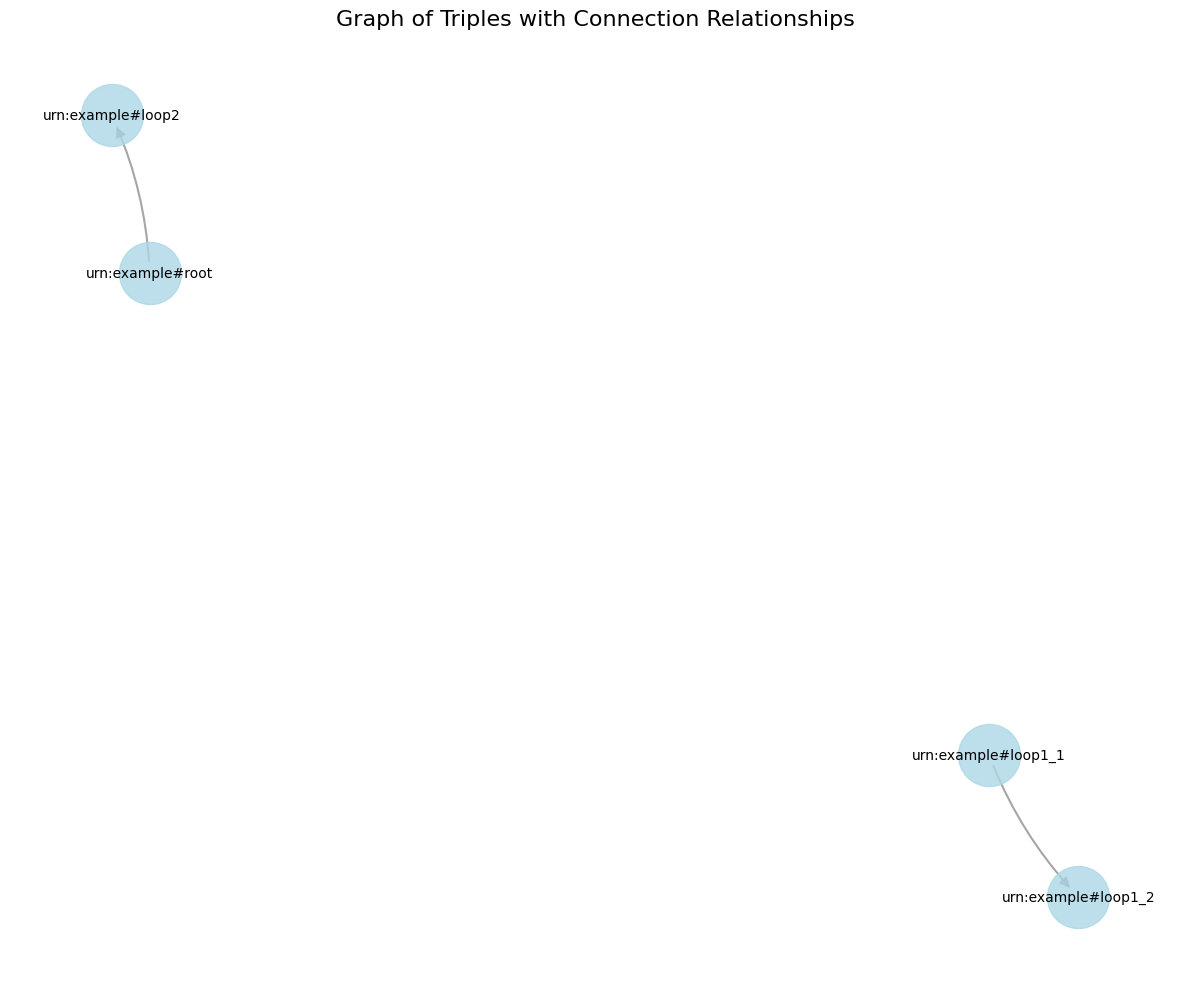

In [ ]:
fig =visualize_triples(b_data)

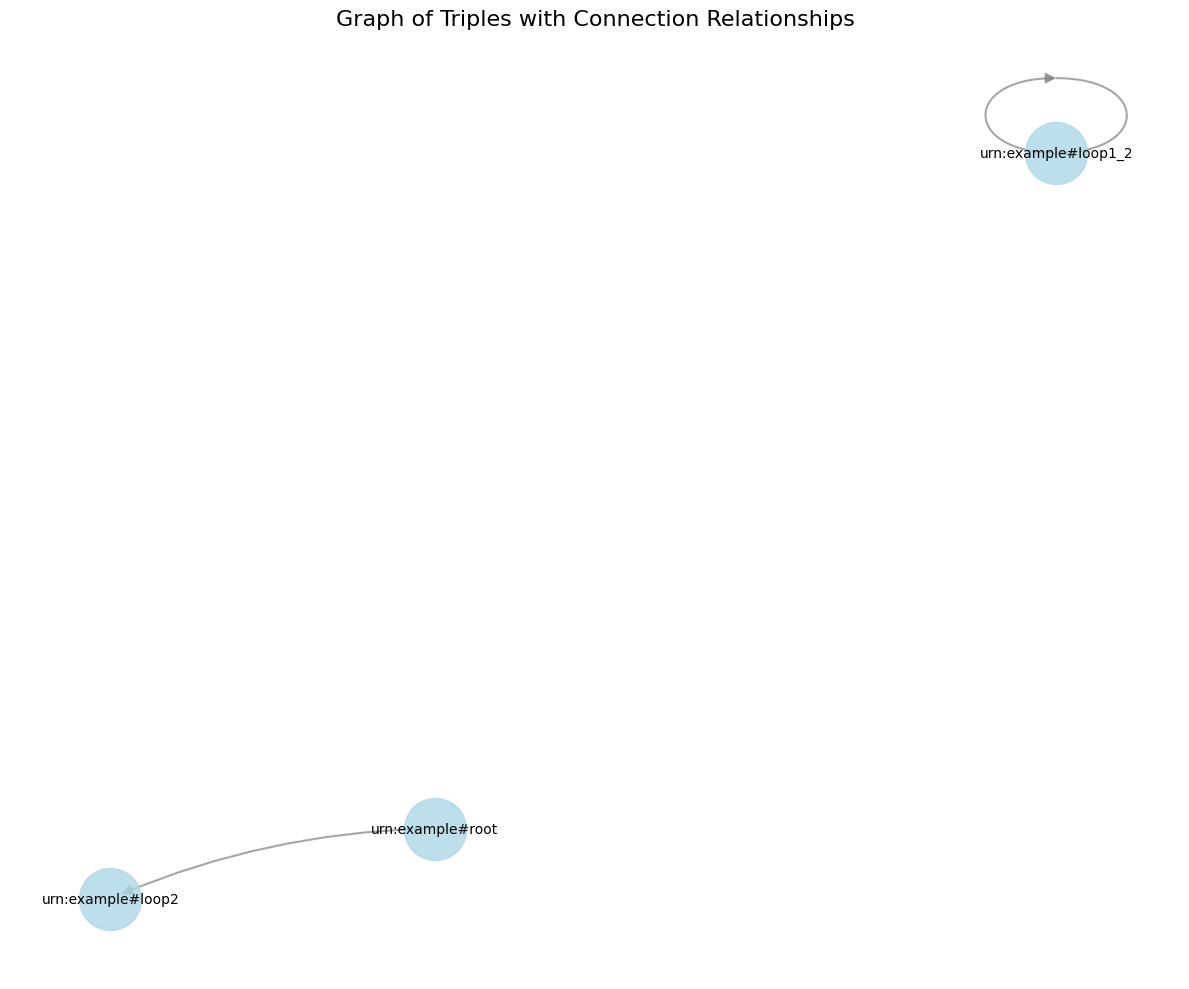

In [ ]:
fig =visualize_triples(b_data_mapped)

ns_prefix s223
getting triples
building query
running query
getting results to list
converting to dataframe
took 0.006071805953979492 seconds
finding overlapped columns
finding sets from pairs
getting_relations
completed getting relations
serializing grouping
[<Variable value=root>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=root>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1_2>, <Variable value=loop2_2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping


[[(<Variable value=loop1>, <Variable value=loop2>),
  (<Variable value=loop1_2>, <Variable value=loop2_2>),
  (<Variable value=loop1_1>, <Variable value=loop2_1>),
  <Variable value=root>],
 [<Variable value=loop1_1_loop2_1>,
  <Variable value=loop1_2_loop2_2>,
  <Variable value=loop1_loop2>,
  <Variable value=root>],
 [<Variable value=loop1_1_loop2_1>,
  <Variable value=loop1_2_loop2_2>,
  <Variable value=loop1_loop2>,
  <Variable value=root>]]

[{'root': [<Variable value=root>],
  'loop1_loop2': [<Variable value=loop1>, <Variable value=loop2>],
  'loop1_1_loop2_1': [<Variable value=loop1_1>, <Variable value=loop2_1>],
  'loop1_2_loop2_2': [<Variable value=loop1_2>, <Variable value=loop2_2>]},
 {'loop1_2_loop2_2': [<Variable value=loop1_2_loop2_2>],
  'loop1_loop2': [<Variable value=loop1_loop2>],
  'loop1_1_loop2_1': [<Variable value=loop1_1_loop2_1>],
  'root': [<Variable value=root>]}]

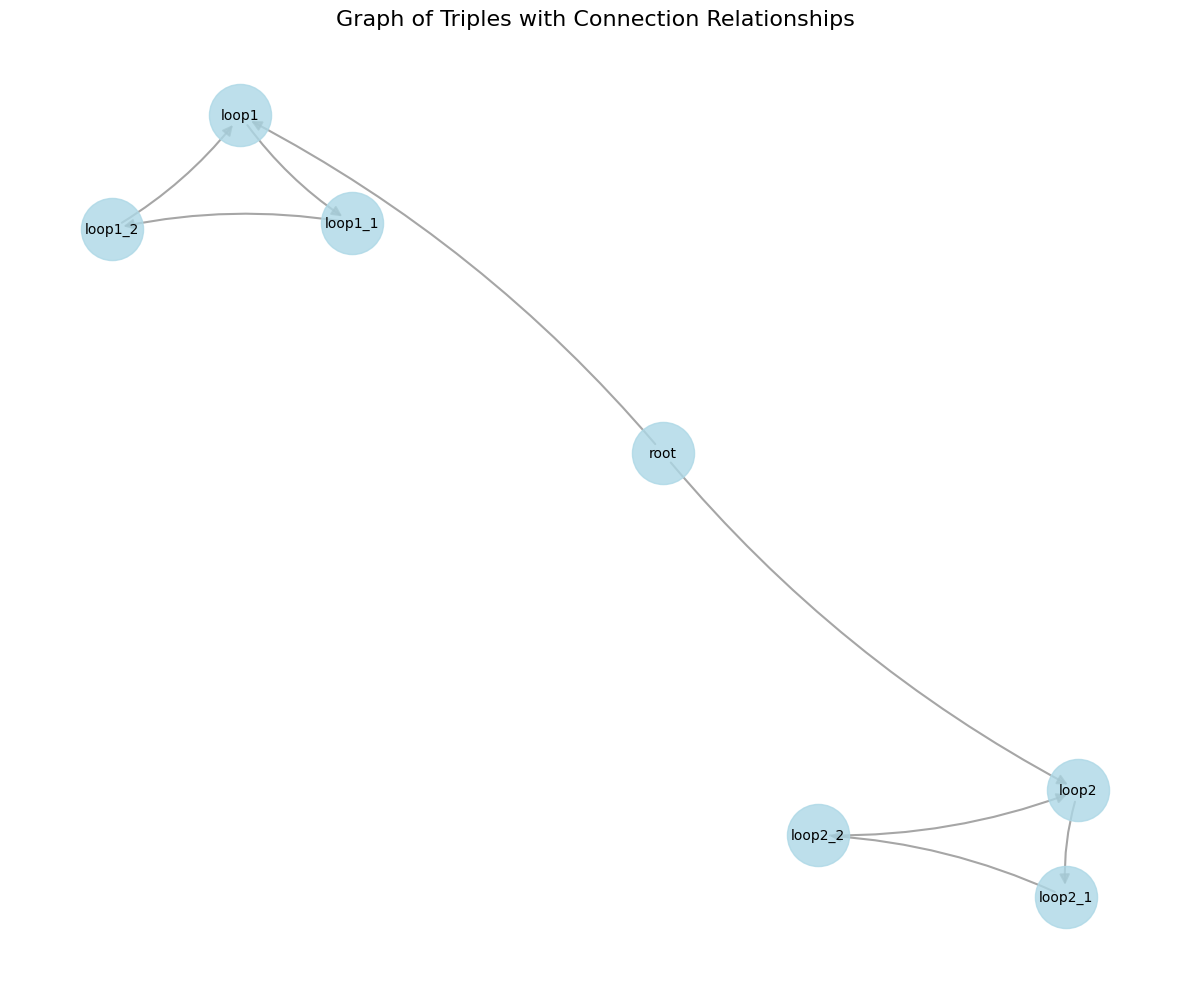

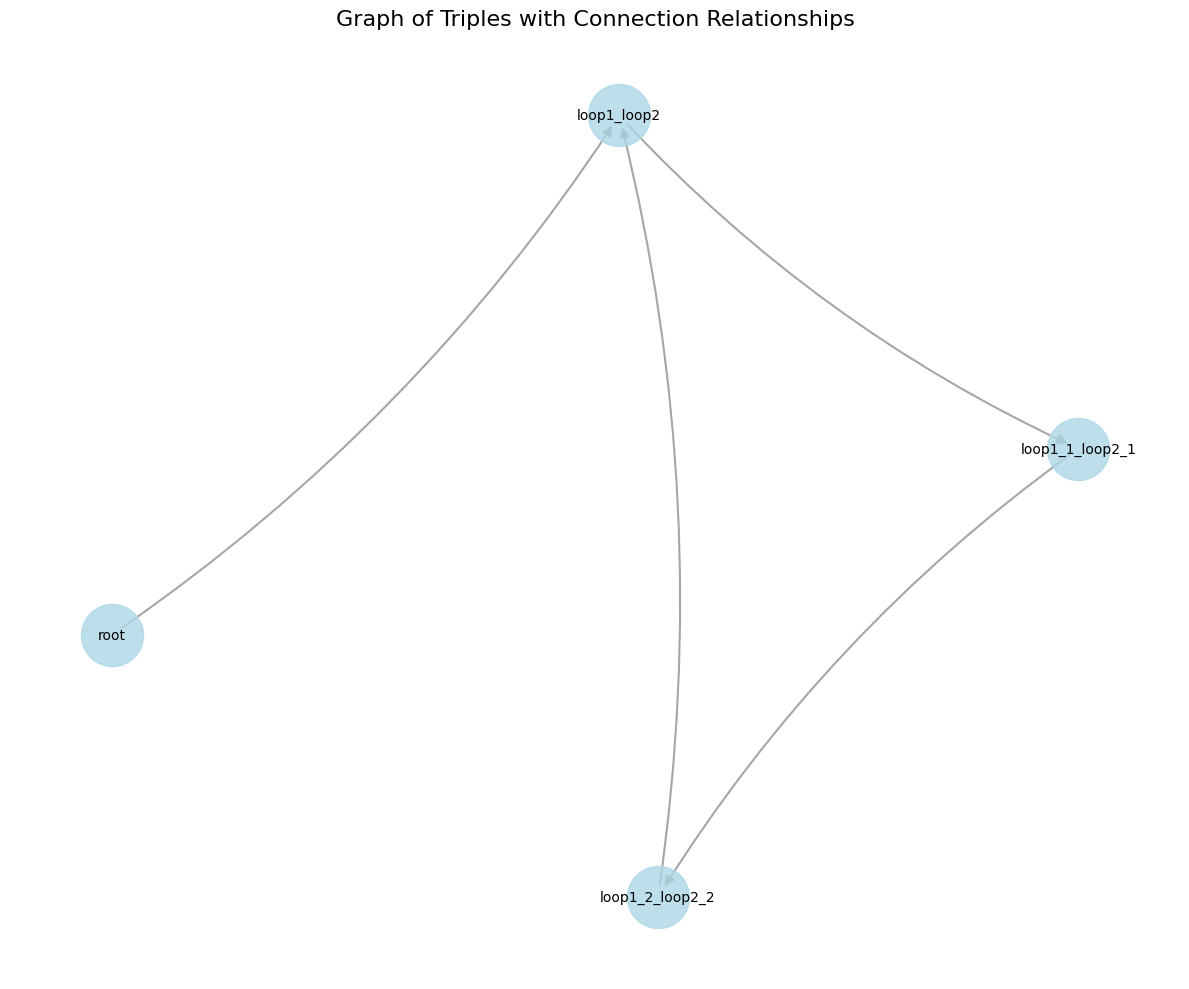

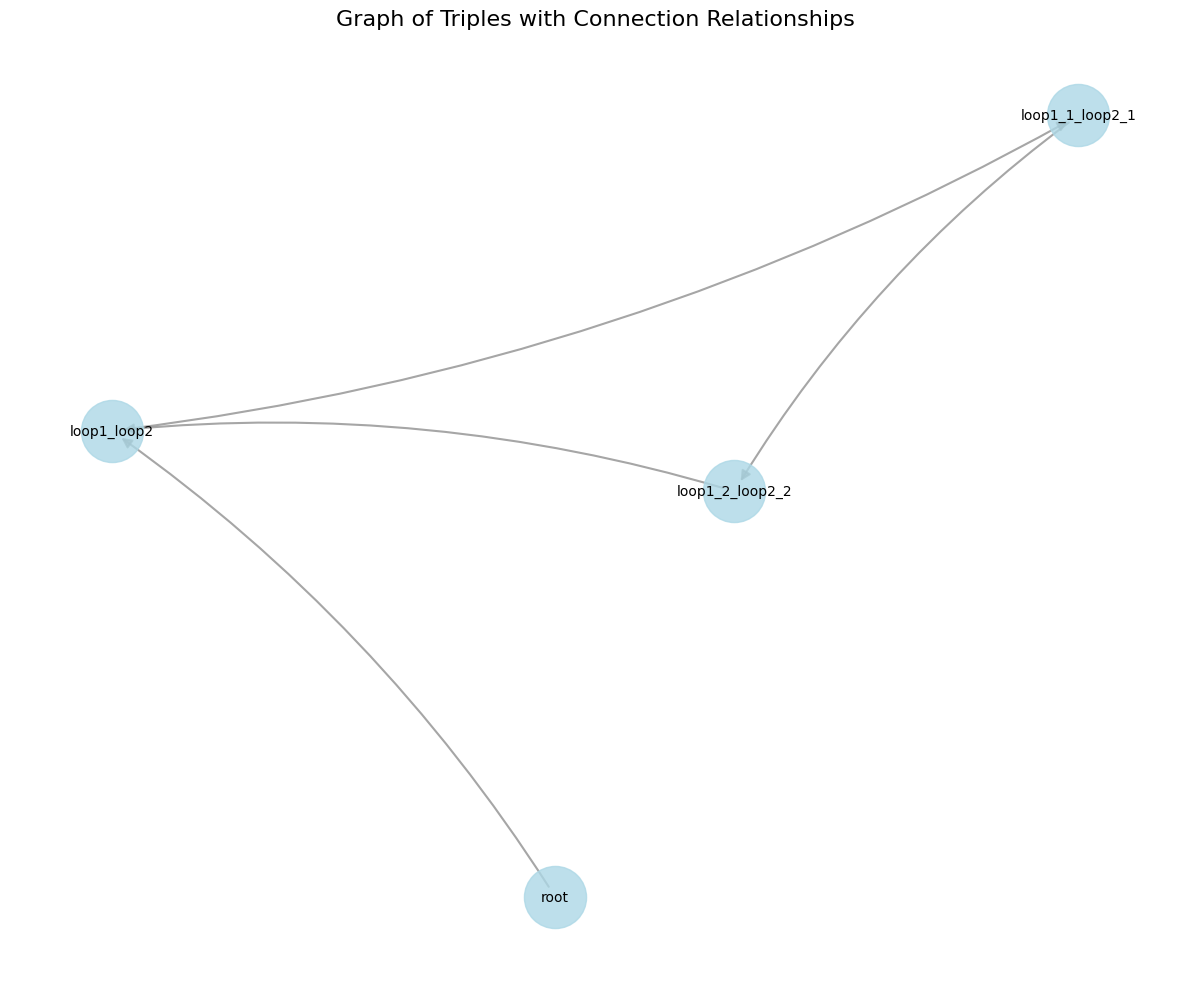

In [ ]:
from group_nodes import GraphPatternProcessor

processor = GraphPatternProcessor(test_graph_file=TEST_GRAPH_FILE, 
                schema_graph_file=SCHEMA_GRAPH_FILE, 
                namespace=S223)

# Process and visualize
all_p, all_sets, group_dicts = processor.process_and_visualize(exempt_predicates=[])

In [ ]:
print(final_query)

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [ ]:
print(query_to_df(final_query, g).to_markdown())

|    | loop1_1             | loop1_2             | loop2             | root             |
|---:|:--------------------|:--------------------|:------------------|:-----------------|
|  0 | urn:example#loop1   | urn:example#loop1_1 | urn:example#loop2 | urn:example#root |
|  1 | urn:example#loop1_1 | urn:example#loop1_2 | urn:example#loop2 | urn:example#root |
|  2 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#loop2 | urn:example#root |
|  3 | urn:example#loop1_2 | urn:example#loop1   | urn:example#loop2 | urn:example#root |
|  4 | urn:example#loop2   | urn:example#loop2_1 | urn:example#loop1 | urn:example#root |
|  5 | urn:example#loop1_1 | urn:example#loop1_2 | urn:example#loop1 | urn:example#root |
|  6 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#loop1 | urn:example#root |
|  7 | urn:example#loop2_2 | urn:example#loop2   | urn:example#loop1 | urn:example#root |


In [ ]:
node_mapping_detailed


{'loop1_1': {'instances': ['urn:example#loop1',
   'urn:example#loop1_1',
   'urn:example#loop1_2',
   'urn:example#loop2',
   'urn:example#loop2_1',
   'urn:example#loop2_2'],
  'count': 6,
  'description': "Variable 'loop1_1' represents 6 distinct node(s): loop1, loop1_1, loop1_2, loop2, loop2_1, loop2_2"},
 'loop1_2': {'instances': ['urn:example#loop1',
   'urn:example#loop1_1',
   'urn:example#loop1_2',
   'urn:example#loop2',
   'urn:example#loop2_1',
   'urn:example#loop2_2'],
  'count': 6,
  'description': "Variable 'loop1_2' represents 6 distinct node(s): loop1, loop1_1, loop1_2, loop2, loop2_1, loop2_2"},
 'loop2': {'instances': ['urn:example#loop1', 'urn:example#loop2'],
  'count': 2,
  'description': "Variable 'loop2' represents 2 distinct node(s): loop1, loop2"},
 'root': {'instances': ['urn:example#root'],
  'count': 1,
  'description': "Variable 'root' represents 1 distinct node(s): root"}}

In [ ]:
query = """
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX wgs: <https://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX bob: <http://data.ashrae.org/standard223/si-builder#>
PREFIX ex1: <http://data.ashrae.org/standard223/data/scb-vrf#>
PREFIX quantitykind: <http://qudt.org/vocab/quantitykind/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX s223: <http://data.ashrae.org/standard223#>
PREFIX unit: <http://qudt.org/vocab/unit/>
CONSTRUCT {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .
} WHERE {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .}
LIMIT 1000"""
query_long = """
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX wgs: <https://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX bob: <http://data.ashrae.org/standard223/si-builder#>
PREFIX ex1: <http://data.ashrae.org/standard223/data/scb-vrf#>
PREFIX quantitykind: <http://qudt.org/vocab/quantitykind/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX s223: <http://data.ashrae.org/standard223#>
PREFIX unit: <http://qudt.org/vocab/unit/>
CONSTRUCT {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .
} WHERE {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .}
LIMIT 100000"""
query_short = """
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX wgs: <https://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX bob: <http://data.ashrae.org/standard223/si-builder#>
PREFIX ex1: <http://data.ashrae.org/standard223/data/scb-vrf#>
PREFIX quantitykind: <http://qudt.org/vocab/quantitykind/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX s223: <http://data.ashrae.org/standard223#>
PREFIX unit: <http://qudt.org/vocab/unit/>
CONSTRUCT {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .
} WHERE {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .}
LIMIT 5"""

In [ ]:
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut.ttl', format = 'ttl')
len(g.query(query).graph)

49

In [ ]:
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut.ttl', format = 'ttl')
len(g.query(query_long).graph)

67

In [ ]:
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut.ttl', format = 'ttl')
len(g.query(query_short).graph)

21

In [ ]:
query_select = """
SELECT *  WHERE {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .}
LIMIT 100000"""
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut.ttl', format = 'ttl')
len(g.query(query_select))

100000

In [ ]:
query_select = """
SELECT (Count(?00048) as ?count)  WHERE {
?00048 a s223:Connection .
?00012 a bob:AirConnectionPoint .
?00048 s223:cnx ?00012 .
?00030 a s223:Filter .
?00045 a s223:Connection .
?00030 s223:connectedThrough ?00045 .
?00019 a bob:AirConnectionPoint .
?00017 a s223:Fan .
?00019 s223:isConnectionPointOf ?00017 .
?00044 a s223:Connection .
?00022 a bob:AirConnectionPoint .
?00044 s223:connectsAt ?00022 .
?00009 a s223:Equipment .
?00012 s223:isConnectionPointOf ?00009 .
?00018 a bob:AirConnectionPoint .
?00027 a s223:FlowSensor .
?00027 rdfs:label ?oa_flow_station .
?00009 s223:hasConnectionPoint ?00012 .
?00021 a s223:Equipment .
?00002 a bob:AirConnectionPoint .}"""
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut.ttl', format = 'ttl')
len(g.query(query_select))

1

In [ ]:
list(g.query(query_select))[0][0].toPython()

26836992

In [ ]:
g

<Graph identifier=Nc9ca3d8ee9044bb1b62efc74561d3bac (<class 'rdflib.graph.Graph'>)>

In [ ]:
import rdflib
from rdflib import Graph, URIRef, Literal
from collections import Counter

def count_nodes(graph: Graph) -> (Counter, Counter, Counter):
    """
    Counts the frequency of each subject, predicate, and object in an rdflib graph.

    Args:
        graph: An rdflib.Graph object.

    Returns:
        A tuple of three collections.Counter objects:
        (subject_counts, predicate_counts, object_counts)
    """
    subject_counts = Counter()
    predicate_counts = Counter()
    object_counts = Counter()
    
    # Iterate through every triple in the graph
    for s, p, o in graph:
        subject_counts[s] += 1
        predicate_counts[p] += 1
        object_counts[o] += 1
        
    return subject_counts, predicate_counts, object_counts

count_nodes(g)[1]

Counter({rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'): 141,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'): 114,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#hasConnectionPoint'): 56,
         rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'): 47,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#connectedThrough'): 44,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#hasProperty'): 36,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#connected'): 36,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#hasMedium'): 35,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#isConnectionPointOf'): 26,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#connectedFrom'): 19,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#connectedTo'): 17,
         rdflib.term.URIRef('http://data.ashrae.org/standard223#connectsAt'): 

In [ ]:
g = Graph(store="Oxigraph")
g.parse('vrf-model-cut-original.ttl', format = 'ttl')
remove = []
for s, p, o in g:
    if ((s, A, None) not in g) or ((o, A, None) not in g):
        remove.append((s, p, o))
len(remove)

430

In [ ]:
for triple in remove:
    g.remove(triple)

In [ ]:
g.serialize('vrf-model-cut.ttl', format = 'ttl')

<Graph identifier=N55b75574a8494cf5b53b6a6a74ca3aa8 (<class 'rdflib.graph.Graph'>)>

In [ ]:
query = """PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX wgs: <https://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
CONSTRUCT {
?vav_cooling_only_co2_0_14 a brick:CO2_Level_Sensor .
?vav_cooling_only_co2_0_14 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_10 a brick:VAV .
?vav_cooling_only_co2_2_10 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_10 brick:hasPoint ?vav_cooling_only_co2_2_10 .
?vav_cooling_only_name_2_6 a brick:VAV .
?vav_cooling_only_co2_2_6 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_6 brick:hasPoint ?vav_cooling_only_co2_2_6 .
?vav_cooling_only_co2_2_10 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_0 a brick:VAV .
?vav_cooling_only_dat_2_0 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_0 brick:hasPoint ?vav_cooling_only_dat_2_0 .
?vav_cooling_only_name_3_10 a brick:VAV .
?vav_cooling_only_ztemp_3_10 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_3_10 brick:hasPoint ?vav_cooling_only_ztemp_3_10 .
?vav_with_reheat_name_1_4 a brick:VAV .
?vav_with_reheat_rhc_1_4 a brick:Heating_Coil .
?vav_with_reheat_name_1_4 brick:hasPart ?vav_with_reheat_rhc_1_4 .
?vav_with_reheat_name_0_7 a brick:VAV .
?vav_with_reheat_name_ztemp_0_7 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_0_7 brick:hasPoint ?vav_with_reheat_name_ztemp_0_7 .
?vav_cooling_only_name_3_13 a brick:VAV .
?vav_cooling_only_name_3_13 rdfs:label ?VAV .
?vav_with_reheat_name_co2_2_12 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_2_12 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_0_4 a brick:VAV .
?vav_with_reheat_name_dat_0_4 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_0_4 brick:hasPoint ?vav_with_reheat_name_dat_0_4 .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_5 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_5 .
?vav_with_reheat_name_1_1 a brick:VAV .
?vav_with_reheat_name_occ_1_1 a brick:Occupancy_Sensor .
?vav_with_reheat_name_1_1 brick:hasPoint ?vav_with_reheat_name_occ_1_1 .
?vav_with_reheat_name_ztemp_0_11 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_1_3 a brick:VAV .
?vav_with_reheat_name_co2_3_8 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_8 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_occ_2_4 a brick:Occupancy_Sensor .
?vav_with_reheat_name_ztemp_3_1 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_co2_1_7 a brick:CO2_Level_Sensor .
?multiple_zone_ahu_name_0 a brick:AHU .
?vav_cooling_only_name_0_5 a brick:VAV .
?multiple_zone_ahu_name_0 brick:feeds ?vav_cooling_only_name_0_5 .
?vav_cooling_only_name_1_10 a brick:VAV .
?vav_cooling_only_zone_1_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_with_reheat_name_0_14 a brick:VAV .
?vav_with_reheat_name_occ_0_14 a brick:Occupancy_Sensor .
?vav_with_reheat_name_0_14 brick:hasPoint ?vav_with_reheat_name_occ_0_14 .
?vav_cooling_only_name_2_12 a brick:VAV .
?vav_cooling_only_dat_2_12 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_1_14 a brick:VAV .
?vav_with_reheat_rhc_1_14 a brick:Heating_Coil .
?vav_with_reheat_name_1_14 brick:hasPart ?vav_with_reheat_rhc_1_14 .
?vav_cooling_only_name_3_6 a brick:VAV .
?vav_with_reheat_name_0_8 a brick:VAV .
?vav_with_reheat_name_zone_0_8 a brick:HVAC_Zone .
?vav_with_reheat_name_0_8 brick:feeds ?vav_with_reheat_name_zone_0_8 .
?vav_with_reheat_name_co2_3_6 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_6 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_2_6 a brick:VAV .
?vav_with_reheat_name_2_6 rdfs:label ?VAV .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_2_8 a brick:VAV .
?vav_with_reheat_name_2_8 rdfs:label ?VAV .
?vav_with_reheat_name_dat_2_6 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_2_6 brick:hasPoint ?vav_with_reheat_name_dat_2_6 .
?vav_with_reheat_rhc_0_0 a brick:Heating_Coil .
?vav_with_reheat_rhc_0_0 rdfs:label ?Heating_Coil .
?vav_with_reheat_name_ztemp_0_8 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_zone_0_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_cooling_only_name_2_3 a brick:VAV .
?vav_cooling_only_name_2_3 rdfs:label ?VAV .
} WHERE {
?vav_cooling_only_co2_0_14 a brick:CO2_Level_Sensor .
?vav_cooling_only_co2_0_14 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_10 a brick:VAV .
?vav_cooling_only_co2_2_10 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_10 brick:hasPoint ?vav_cooling_only_co2_2_10 .
?vav_cooling_only_name_2_6 a brick:VAV .
?vav_cooling_only_co2_2_6 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_6 brick:hasPoint ?vav_cooling_only_co2_2_6 .
?vav_cooling_only_co2_2_10 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_0 a brick:VAV .
?vav_cooling_only_dat_2_0 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_0 brick:hasPoint ?vav_cooling_only_dat_2_0 .
?vav_cooling_only_name_3_10 a brick:VAV .
?vav_cooling_only_ztemp_3_10 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_3_10 brick:hasPoint ?vav_cooling_only_ztemp_3_10 .
?vav_with_reheat_name_1_4 a brick:VAV .
?vav_with_reheat_rhc_1_4 a brick:Heating_Coil .
?vav_with_reheat_name_1_4 brick:hasPart ?vav_with_reheat_rhc_1_4 .
?vav_with_reheat_name_0_7 a brick:VAV .
?vav_with_reheat_name_ztemp_0_7 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_0_7 brick:hasPoint ?vav_with_reheat_name_ztemp_0_7 .
?vav_cooling_only_name_3_13 a brick:VAV .
?vav_cooling_only_name_3_13 rdfs:label ?VAV .
?vav_with_reheat_name_co2_2_12 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_2_12 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_0_4 a brick:VAV .
?vav_with_reheat_name_dat_0_4 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_0_4 brick:hasPoint ?vav_with_reheat_name_dat_0_4 .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_5 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_5 .
?vav_with_reheat_name_1_1 a brick:VAV .
?vav_with_reheat_name_occ_1_1 a brick:Occupancy_Sensor .
?vav_with_reheat_name_1_1 brick:hasPoint ?vav_with_reheat_name_occ_1_1 .
?vav_with_reheat_name_ztemp_0_11 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_1_3 a brick:VAV .
?vav_with_reheat_name_co2_3_8 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_8 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_occ_2_4 a brick:Occupancy_Sensor .
?vav_with_reheat_name_ztemp_3_1 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_co2_1_7 a brick:CO2_Level_Sensor .
?multiple_zone_ahu_name_0 a brick:AHU .
?vav_cooling_only_name_0_5 a brick:VAV .
?multiple_zone_ahu_name_0 brick:feeds ?vav_cooling_only_name_0_5 .
?vav_cooling_only_name_1_10 a brick:VAV .
?vav_cooling_only_zone_1_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_with_reheat_name_0_14 a brick:VAV .
?vav_with_reheat_name_occ_0_14 a brick:Occupancy_Sensor .
?vav_with_reheat_name_0_14 brick:hasPoint ?vav_with_reheat_name_occ_0_14 .
?vav_cooling_only_name_2_12 a brick:VAV .
?vav_cooling_only_dat_2_12 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_1_14 a brick:VAV .
?vav_with_reheat_rhc_1_14 a brick:Heating_Coil .
?vav_with_reheat_name_1_14 brick:hasPart ?vav_with_reheat_rhc_1_14 .
?vav_cooling_only_name_3_6 a brick:VAV .
?vav_with_reheat_name_0_8 a brick:VAV .
?vav_with_reheat_name_zone_0_8 a brick:HVAC_Zone .
?vav_with_reheat_name_0_8 brick:feeds ?vav_with_reheat_name_zone_0_8 .
?vav_with_reheat_name_co2_3_6 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_6 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_2_6 a brick:VAV .
?vav_with_reheat_name_2_6 rdfs:label ?VAV .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_2_8 a brick:VAV .
?vav_with_reheat_name_2_8 rdfs:label ?VAV .
?vav_with_reheat_name_dat_2_6 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_2_6 brick:hasPoint ?vav_with_reheat_name_dat_2_6 .
?vav_with_reheat_rhc_0_0 a brick:Heating_Coil .
?vav_with_reheat_rhc_0_0 rdfs:label ?Heating_Coil .
?vav_with_reheat_name_ztemp_0_8 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_zone_0_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_cooling_only_name_2_3 a brick:VAV .
?vav_cooling_only_name_2_3 rdfs:label ?VAV .
}LIMIT 342"""

In [ ]:
query = """PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX wgs: <https://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
SELECT * WHERE {
?vav_cooling_only_co2_0_14 a brick:CO2_Level_Sensor .
?vav_cooling_only_co2_0_14 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_10 a brick:VAV .
?vav_cooling_only_co2_2_10 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_10 brick:hasPoint ?vav_cooling_only_co2_2_10 .
?vav_cooling_only_name_2_6 a brick:VAV .
?vav_cooling_only_co2_2_6 a brick:CO2_Level_Sensor .
?vav_cooling_only_name_2_6 brick:hasPoint ?vav_cooling_only_co2_2_6 .
?vav_cooling_only_co2_2_10 rdfs:label ?CO2_Level_Sensor .
?vav_cooling_only_name_2_0 a brick:VAV .
?vav_cooling_only_dat_2_0 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_0 brick:hasPoint ?vav_cooling_only_dat_2_0 .
?vav_cooling_only_name_3_10 a brick:VAV .
?vav_cooling_only_ztemp_3_10 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_3_10 brick:hasPoint ?vav_cooling_only_ztemp_3_10 .
?vav_with_reheat_name_1_4 a brick:VAV .
?vav_with_reheat_rhc_1_4 a brick:Heating_Coil .
?vav_with_reheat_name_1_4 brick:hasPart ?vav_with_reheat_rhc_1_4 .
?vav_with_reheat_name_0_7 a brick:VAV .
?vav_with_reheat_name_ztemp_0_7 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_0_7 brick:hasPoint ?vav_with_reheat_name_ztemp_0_7 .
?vav_cooling_only_name_3_13 a brick:VAV .
?vav_cooling_only_name_3_13 rdfs:label ?VAV .
?vav_with_reheat_name_co2_2_12 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_2_12 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_0_4 a brick:VAV .
?vav_with_reheat_name_dat_0_4 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_0_4 brick:hasPoint ?vav_with_reheat_name_dat_0_4 .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_5 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_5 .
?vav_with_reheat_name_1_1 a brick:VAV .
?vav_with_reheat_name_occ_1_1 a brick:Occupancy_Sensor .
?vav_with_reheat_name_1_1 brick:hasPoint ?vav_with_reheat_name_occ_1_1 .
?vav_with_reheat_name_ztemp_0_11 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_name_1_3 a brick:VAV .
?vav_with_reheat_name_co2_3_8 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_8 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_occ_2_4 a brick:Occupancy_Sensor .
?vav_with_reheat_name_ztemp_3_1 a brick:Zone_Air_Temperature_Sensor .
?vav_cooling_only_co2_1_7 a brick:CO2_Level_Sensor .
?multiple_zone_ahu_name_0 a brick:AHU .
?vav_cooling_only_name_0_5 a brick:VAV .
?multiple_zone_ahu_name_0 brick:feeds ?vav_cooling_only_name_0_5 .
?vav_cooling_only_name_1_10 a brick:VAV .
?vav_cooling_only_zone_1_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_with_reheat_name_0_14 a brick:VAV .
?vav_with_reheat_name_occ_0_14 a brick:Occupancy_Sensor .
?vav_with_reheat_name_0_14 brick:hasPoint ?vav_with_reheat_name_occ_0_14 .
?vav_cooling_only_name_2_12 a brick:VAV .
?vav_cooling_only_dat_2_12 a brick:Discharge_Air_Temperature_Sensor .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_1_14 a brick:VAV .
?vav_with_reheat_rhc_1_14 a brick:Heating_Coil .
?vav_with_reheat_name_1_14 brick:hasPart ?vav_with_reheat_rhc_1_14 .
?vav_cooling_only_name_3_6 a brick:VAV .
?vav_with_reheat_name_0_8 a brick:VAV .
?vav_with_reheat_name_zone_0_8 a brick:HVAC_Zone .
?vav_with_reheat_name_0_8 brick:feeds ?vav_with_reheat_name_zone_0_8 .
?vav_with_reheat_name_co2_3_6 a brick:CO2_Level_Sensor .
?vav_with_reheat_name_co2_3_6 rdfs:label ?CO2_Level_Sensor .
?vav_with_reheat_name_2_6 a brick:VAV .
?vav_with_reheat_name_2_6 rdfs:label ?VAV .
?vav_cooling_only_name_2_12 brick:hasPoint ?vav_cooling_only_dat_2_12 .
?vav_with_reheat_name_2_8 a brick:VAV .
?vav_with_reheat_name_2_8 rdfs:label ?VAV .
?vav_with_reheat_name_dat_2_6 a brick:Discharge_Air_Temperature_Sensor .
?vav_with_reheat_name_2_6 brick:hasPoint ?vav_with_reheat_name_dat_2_6 .
?vav_with_reheat_rhc_0_0 a brick:Heating_Coil .
?vav_with_reheat_rhc_0_0 rdfs:label ?Heating_Coil .
?vav_with_reheat_name_ztemp_0_8 a brick:Zone_Air_Temperature_Sensor .
?vav_with_reheat_name_zone_0_10 a brick:HVAC_Zone .
?vav_cooling_only_name_1_10 brick:feeds ?vav_cooling_only_zone_1_10 .
?vav_cooling_only_name_2_3 a brick:VAV .
?vav_cooling_only_name_2_3 rdfs:label ?VAV .
}LIMIT 1"""

In [85]:
query = """SELECT * WHERE {?vav_with_reheat_name_1_9 a brick:VAV .
?vav_with_reheat_rhc_1_9 a brick:Heating_Coil .
?vav_with_reheat_name_1_9 brick:hasPart ?vav_with_reheat_rhc_1_9 .
?vav_with_reheat_name_2_10 a brick:VAV .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_9 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_9 .
?vav_with_reheat_rhc_1_0 a brick:Heating_Coil .} LIMIT 1 OFFSET 50"""

In [86]:
g = Graph(store="Oxigraph")
g.parse('brick-example.ttl', format = 'ttl')
res = list(g.query(query))
pprint(res)

[(rdflib.term.URIRef('urn:example#multiple-zone-ahu_name_0'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_name_3_9'),
  rdflib.term.URIRef('urn:example#vav-cooling-only_name_0_0'),
  rdflib.term.URIRef('urn:example#vav-cooling-only_name_0_0'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_1'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_9'))]


In [91]:
query = """SELECT * WHERE {?vav_with_reheat_name_1_9 a brick:VAV .
?vav_with_reheat_rhc_1_9 a brick:Heating_Coil .
?vav_with_reheat_name_1_9 brick:hasPart ?vav_with_reheat_rhc_1_9 .
?vav_with_reheat_name_2_10 a brick:VAV .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_9 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_9 .
?vav_with_reheat_rhc_1_0 a brick:Heating_Coil . FILTER (?multiple_zone_ahu_name_3 != <urn:example#multiple-zone-ahu_name_0>)} LIMIT 1 OFFSET 50"""

In [ ]:
g = Graph(store="Oxigraph")
g.parse('brick-example.ttl', format = 'ttl')
res = g.query(query)

In [97]:
res.bindings

[{rdflib.term.Variable('multiple_zone_ahu_name_3'): rdflib.term.URIRef('urn:example#multiple-zone-ahu_name_1'),
  rdflib.term.Variable('vav_with_reheat_name_1_9'): rdflib.term.URIRef('urn:example#vav-with-reheat_name_3_9'),
  rdflib.term.Variable('vav_with_reheat_name_2_10'): rdflib.term.URIRef('urn:example#vav-cooling-only_name_0_0'),
  rdflib.term.Variable('vav_with_reheat_name_3_9'): rdflib.term.URIRef('urn:example#vav-cooling-only_name_1_0'),
  rdflib.term.Variable('vav_with_reheat_rhc_1_0'): rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_1'),
  rdflib.term.Variable('vav_with_reheat_rhc_1_9'): rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_9')}]

In [113]:
filter = []
for k,v in res.bindings[0].items():
    filter.append(f"FILTER (?{k} != <{v}>) .")
filter_statement = "\n".join(filter)

In [114]:
query = f"""SELECT * WHERE {{?vav_with_reheat_name_1_9 a brick:VAV .
?vav_with_reheat_rhc_1_9 a brick:Heating_Coil .
?vav_with_reheat_name_1_9 brick:hasPart ?vav_with_reheat_rhc_1_9 .
?vav_with_reheat_name_2_10 a brick:VAV .
?multiple_zone_ahu_name_3 a brick:AHU .
?vav_with_reheat_name_3_9 a brick:VAV .
?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_9 .
?vav_with_reheat_rhc_1_0 a brick:Heating_Coil . 
{filter_statement}
}} LIMIT 1 OFFSET 50"""

In [115]:
g = Graph(store="Oxigraph")
g.parse('brick-example.ttl', format = 'ttl')
res = g.query(query)

In [117]:
pprint(list(res))

[(rdflib.term.URIRef('urn:example#multiple-zone-ahu_name_0'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_name_3_8'),
  rdflib.term.URIRef('urn:example#vav-cooling-only_name_0_1'),
  rdflib.term.URIRef('urn:example#vav-cooling-only_name_0_0'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_10'),
  rdflib.term.URIRef('urn:example#vav-with-reheat_rhc_3_8'))]


In [ ]:

filter = []
g = Graph(store="Oxigraph")
g.parse('brick-example.ttl', format = 'ttl')
# count AHUs

# can run a query on a specific triple to get approximate count (e.g. if there are 4 AHUs that means I can only have 3 filters )
while res != []:

    filter_statement = "\n".join(filter)
    query = f"""SELECT * WHERE {{?vav_with_reheat_name_1_9 a brick:VAV .
    ?vav_with_reheat_rhc_1_9 a brick:Heating_Coil .
    ?vav_with_reheat_name_1_9 brick:hasPart ?vav_with_reheat_rhc_1_9 .
    ?vav_with_reheat_name_2_10 a brick:VAV .
    ?multiple_zone_ahu_name_3 a brick:AHU .
    ?vav_with_reheat_name_3_9 a brick:VAV .
    ?multiple_zone_ahu_name_3 brick:feeds ?vav_with_reheat_name_3_9 .
    ?vav_with_reheat_rhc_1_0 a brick:Heating_Coil . 
    {filter_statement}
    }} LIMIT 1"""
    
    res = g.query(query)

    for k,v in res.bindings[0].items():
        filter.append(f"FILTER (?{k} != <{v}>) .")

IndexError: list index out of range